### Langchina Chunking
- Preparing Text Data for use with Retrieval-Augmented LLMs


In [1]:
from langchain.document_loaders import ReadTheDocsLoader

- get am sample html doc ; the following commend will get all links in the page recursively 
- !wget -r -A.html -P rtdocs https://langchain.readthedocs.io/en/latest/

In [13]:
#### ReadTheDocsLoader is used for parsing htmls 
loader = ReadTheDocsLoader('data')
docs = loader.load()
len(docs)

2

In [20]:
#### basic data exploration
print(docs[0].page_content[:1000])

.rst
.pdf
Agents
 Contents 
Action Agents
Plan-and-Execute Agents
Agents#
Note
Conceptual Guide
Some applications require not just a predetermined chain of calls to LLMs/other tools,
but potentially an unknown chain that depends on the userâ€™s input.
In these types of chains, there is an agent which has access to a suite of tools.
Depending on the user input, the agent can then decide which, if any, of these tools to call.
At the moment, there are two main types of agents:
Action Agents: these agents decide the actions to take and execute that actions one action at a time.
Plan-and-Execute Agents: these agents first decide a plan of actions to take, and then execute those actions one at a time.
When should you use each one? Action Agents are more conventional, and good for small tasks.
For more complex or long running tasks, the initial planning step helps to maintain long term objectives and focus.
However, that comes at the expense of generally more calls and higher latency.
These t

##### use a gpt tokenizer to count tokens
- https://github.com/openai/tiktoken/blob/main/tiktoken/model.py
- you can read the tiktoken doc, for which version of tokenizer you should use 

In [27]:
import tiktoken

print(tiktoken.encoding_for_model('gpt-3.5-turbo'))
tokenizer = tiktoken.get_encoding('cl100k_base')
# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

<Encoding 'cl100k_base'>


In [31]:
## some summary statistics 
token_counts = [tiktoken_len(doc.page_content) for doc in docs]
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 910
Avg: 1011
Max: 1113


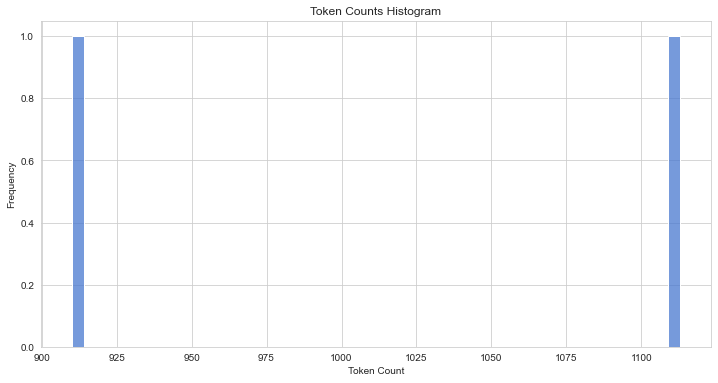

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

### Chunking the Text

At the time of writing, gpt-3.5-turbo supports a context window of 4096 tokens — that means that input tokens + generated ( / completion) output tokens, cannot total more than 4096 without hitting an error.


With the length function defined we can initialize our RecursiveCharacterTextSplitter object like so:

In [40]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

- let's create a unique id for each page and each chunk 

In [33]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

In [38]:
### one example 
url = docs[0].metadata['source'].replace('data/', 'https://')
print(url)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

data\Agents — 🦜🔗 LangChain 0.0.195.html
92aed2339c4d


In [41]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('data/', 'https://')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)

  0%|          | 0/2 [00:00<?, ?it/s]

7

In [42]:
documents[0]

{'id': '4aa271fd7436-0',
 'text': '.rst\n.pdf\nAgents\n Contents \nAction Agents\nPlan-and-Execute Agents\nAgents#\nNote\nConceptual Guide\nSome applications require not just a predetermined chain of calls to LLMs/other tools,\nbut potentially an unknown chain that depends on the userâ€™s input.\nIn these types of chains, there is an agent which has access to a suite of tools.\nDepending on the user input, the agent can then decide which, if any, of these tools to call.\nAt the moment, there are two main types of agents:\nAction Agents: these agents decide the actions to take and execute that actions one action at a time.\nPlan-and-Execute Agents: these agents first decide a plan of actions to take, and then execute those actions one at a time.\nWhen should you use each one? Action Agents are more conventional, and good for small tasks.\nFor more complex or long running tasks, the initial planning step helps to maintain long term objectives and focus.\nHowever, that comes at the expens

#### Save to jsonl so that is it compatable with huggingface datasets 

In [43]:
import json

with open('data/train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')

In [45]:
documents = []

with open('data/train.jsonl', 'r') as f:
    for line in f:
        documents.append(json.loads(line))

documents[0]

{'id': '4aa271fd7436-0',
 'text': '.rst\n.pdf\nAgents\n Contents \nAction Agents\nPlan-and-Execute Agents\nAgents#\nNote\nConceptual Guide\nSome applications require not just a predetermined chain of calls to LLMs/other tools,\nbut potentially an unknown chain that depends on the userâ€™s input.\nIn these types of chains, there is an agent which has access to a suite of tools.\nDepending on the user input, the agent can then decide which, if any, of these tools to call.\nAt the moment, there are two main types of agents:\nAction Agents: these agents decide the actions to take and execute that actions one action at a time.\nPlan-and-Execute Agents: these agents first decide a plan of actions to take, and then execute those actions one at a time.\nWhen should you use each one? Action Agents are more conventional, and good for small tasks.\nFor more complex or long running tasks, the initial planning step helps to maintain long term objectives and focus.\nHowever, that comes at the expens

### More advance parsing strategy
- https://www.arxiv-vanity.com/papers/1503.05543/